### FILE PURPOSE: TESTING SCRAPED PUBLIC REPOSITORY AE's

In [70]:
# IMPORT EVERYTHING****!!!
from Data.load import load
from Visualizations.latent_space_projections import pPCA, pTSNE, pUMAP, pISOMAP, pENCODED, plot_multiple_datasets
from Visualizations.plots import plot_middle_slices_in_range, plot_models_training_time, compare_models_loss_history, plot_images, compare_models_reconstruction
from Architectures.AE_ADJ import AE
from Metrics.metrics_tf import MSE_loss, NMSE_loss, NRMSE_loss, SSIM_loss
from Metrics.metrics import NMSE, SSIM, NRMSE


from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers, Model, models, Input, activations, regularizers
from skimage.metrics import structural_similarity as ssim

import umap
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import tensorflow as tf
import tensorflow.keras.backend as K
import time
import math
import nibabel as nib


In [2]:
train, test = load(dataset_name="Pre-processed", take=100, train_test_split=0.8) # spatially normalized brains were put in this path "\Data\Pre-processed"
A, B = load(dataset_name="Pre-processed-AD", take=30, train_test_split=0.8)
C, D = load(dataset_name="Pre-processed-MCI", take=30, train_test_split=0.8)
print(train.shape, test.shape)
print(A.shape, B.shape)
print(C.shape, D.shape)
AD  = np.concatenate([A, B], axis=0)
MCI = np.concatenate([C, D], axis=0)
H   = np.concatenate([train, test], axis=0)

Loading images:   0%|          | 0/100 [00:00<?, ?it/s]

Loading images: 100%|██████████| 30/30 [00:08<00:00,  3.41it/s]

(80, 80, 96, 80) (20, 80, 96, 80)
(20, 80, 96, 80) (6, 80, 96, 80)
(24, 80, 96, 80) (6, 80, 96, 80)


In [ ]:
plot_middle_slices_in_range(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\Data\Pre-processed", 0, 9)

In [ ]:
E = AE(name="E",
    input_shape=train.shape,
    latent_dim=128,
    encoder_layers=[
        (layers.Conv3D, 2, (2,2,2), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), layers.LeakyReLU(),
        (layers.Conv3D, 4, (2,2,2), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), layers.LeakyReLU(),
        #(layers.Conv3D, 8, (2,2,2), {'strides': 2, 'padding': 'same', 'activation': 'relu'}) #layers.BatchNormalization(), layers.LeakyReLU()
    ],
    decoder_layers=[
        # decoder.append(Conv2DTranspose(filters=filters, kernel_size=5, strides=2, padding='same', name=f'dec_Conv2DT_{i}'))
        # decoder.append(BatchNormalization() if use_batchnorm else LayerNormalization([1, 2]))
        # decoder.append(LeakyReLU())
        #(layers.Conv3D, 8, (2,2,2), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 4, (2,2,2), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 2, (2,2,2), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 1, (2,2,2), {'padding': 'same'}),
        # decoder.append(Conv2DTranspose(filters=filters, kernel_size=5, strides=2, padding='same', name=f'dec_Conv2DT_{i}'))
        # decoder.append(BatchNormalization() if use_batchnorm else LayerNormalization([1, 2]))
        # decoder.append(LeakyReLU())
    ], VAE_model=False, loss="mse")

Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 20, 24, 20, 4)


In [89]:
#for m in models_list4:
E.train(train, epochs=25, batch_size=10, verbose=True,
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models", 
    save_interval=100) # saves every 100 epoch btw

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - loss: 0.0039 - val_loss: 0.0038
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 0.0038 - val_loss: 0.0037
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - loss: 0.0038 - val_loss: 0.0037
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - loss: 0.0037 - val_loss: 0.0038
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0037 - val_loss: 0.0037
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.0037 - val_loss: 0.0036
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0035 - val_loss: 0.0036
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.0035 - val_loss: 0.0036
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.0035 - val_loss: 0.0036
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.0033 - val_loss: 0.0036
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 0.0033 - val_loss: 0.0036
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.0033 - val_loss: 0.0036
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 0.0033 - val_loss: 0.0036
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 0.00

{'loss': [0.046742577105760574,
  0.010082907974720001,
  0.006410693749785423,
  0.005450372584164143,
  0.005081398878246546,
  0.00486132362857461,
  0.004757011774927378,
  0.004706788808107376,
  0.004649917595088482,
  0.004616717807948589,
  0.004590841010212898,
  0.00458131730556488,
  0.004566978197544813,
  0.004544850438833237,
  0.004567482974380255,
  0.004517736844718456,
  0.004515543580055237,
  0.004480371251702309,
  0.004458695650100708,
  0.004430738743394613,
  0.004374118987470865,
  0.004302388057112694,
  0.004202713258564472,
  0.004108146298676729,
  0.0040144119411706924,
  0.003936302848160267,
  0.0038696934934705496,
  0.003786058397963643,
  0.003730237949639559,
  0.0036938132252544165,
  0.0036252178251743317,
  0.0035764125641435385,
  0.0035174048971384764,
  0.0034804597962647676,
  0.0034330543130636215,
  0.0033931529615074396,
  0.003342802869156003,
  0.0033161018509417772,
  0.003268316388130188,
  0.0032172231003642082,
  0.00320353708229959,


In [86]:
models_list4 = [A,E]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


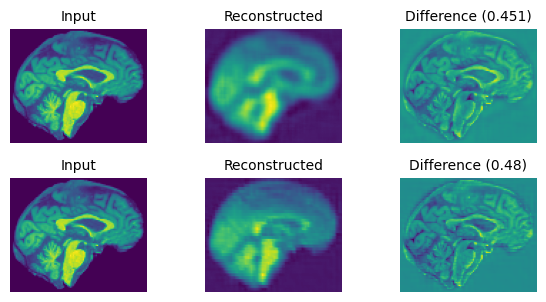

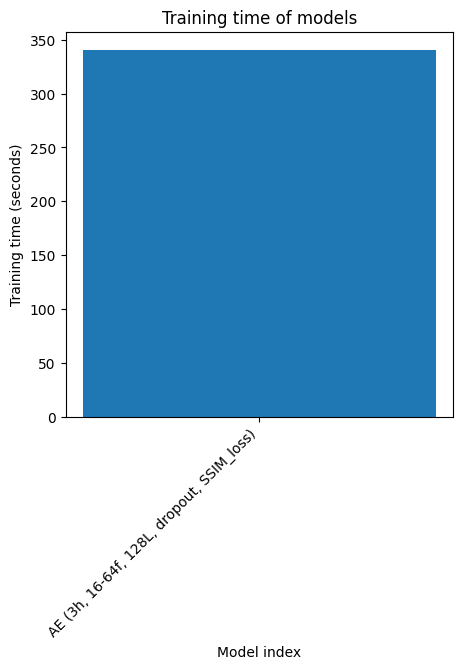

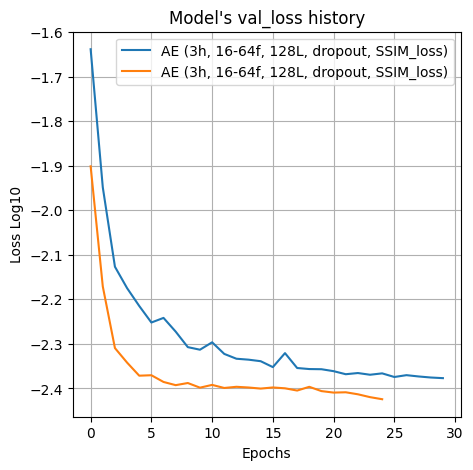

In [87]:
if 'models_list4' in locals(): # if the variable exists
    images, latent, titles = compare_models_reconstruction(brain_scan_id=0, models_list=models_list4, test=test, loss=SSIM)
    #print(latent)
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=titles, top_title="")

    plot_models_training_time(models_list4, fig_size=(5,5))
    compare_models_loss_history(models_list4, log10=True, fig_size=(5,5))